In [ ]:
%pip install pandas==1.3.3
%pip install scikit-learn==0.24.2
%pip install matplotlib==3.4.3
%pip install seaborn==0.11.2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

In [3]:
google_ads_df = pd.read_csv('googleads-performance.csv')
meta_ads_df = pd.read_csv('metaads-performance.csv')
microsoft_ads_df = pd.read_csv('microsoftads-performance.csv')
website_landings_df = pd.read_csv('website-landings.csv')

In [7]:
print(google_ads_df.head())
print(meta_ads_df.head())
print(microsoft_ads_df.head())
print(website_landings_df.head())

         Date    Campaign type  Impressions  Clicks    Cost  Conversions  \
0  2024-01-01    Cross-network     143669.0   896.0   656.3          6.5   
1  2024-01-01  Display Network          3.0     0.0     0.0          0.0   
2  2024-01-01   Search Network       3701.0   251.0   496.5          4.5   
3  2024-01-01          YouTube      36211.0     8.0   115.2          0.0   
4  2024-01-02    Cross-network     183496.0  1172.0  1525.0          8.8   

   Revenue  
0   1410.3  
1      0.0  
2    576.4  
3      0.0  
4   3565.7  
         Date  Impressions    Reach   Cost  Clicks  Conversions  Revenue
0  2024-01-01      36034.0  27263.0  209.1   608.0          4.0    158.2
1  2024-01-02      30804.0  22648.0  204.9   516.0         11.0   1412.8
2  2024-01-03      26372.0  18947.0  198.7   429.0          4.0    371.5
3  2024-01-04      17354.0  11436.0  131.2   324.0          4.0      0.0
4  2024-01-05      12036.0   7921.0  114.0   224.0          2.0      0.0
         Date     Campaign 

In [14]:
def preprocess_ads_data(df, platform):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')  # Corrected format
    df['Platform'] = platform
    df.fillna(0, inplace=True)
    return df

In [15]:
google_ads_df = preprocess_ads_data(google_ads_df, 'Google Ads')
meta_ads_df = preprocess_ads_data(meta_ads_df, 'Meta Ads')
microsoft_ads_df = preprocess_ads_data(microsoft_ads_df, 'Microsoft Ads')

In [16]:
ads_data = pd.concat([google_ads_df, meta_ads_df, microsoft_ads_df], axis=0)

#### Analyze Customer Journey

In [19]:
website_landings_df['Website Landing Time'] = pd.to_datetime(website_landings_df['Website Landing Time'], format='%Y-%m-%d %H:%M:%S')
website_landings_df['Is Converted'] = website_landings_df['Is Converted'].astype(int)


In [20]:
# Feature Engineering: Aggregating Data
ads_data['CTR'] = ads_data['Clicks'] / ads_data['Impressions']
ads_data['CPC'] = ads_data['Cost'] / ads_data['Clicks']
ads_data['CPM'] = ads_data['Cost'] / ads_data['Impressions'] * 1000

In [21]:
# Summarize performance by platform and campaign
performance_summary = ads_data.groupby(['Platform', 'Campaign type']).agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Cost': 'sum',
    'Conversions': 'sum',
    'Revenue': 'sum'
}).reset_index()

In [22]:
print(performance_summary)

        Platform     Campaign type  Impressions    Clicks      Cost  \
0     Google Ads     Cross-network   68183796.0  385470.0  577335.4   
1     Google Ads   Display Network       9355.0      25.0      57.6   
2     Google Ads    Search Network    1559847.0   90721.0  258220.7   
3     Google Ads           YouTube    3966995.0    1002.0   17191.6   
4  Microsoft Ads          Audience    2078054.0   10966.0    4383.8   
5  Microsoft Ads   Performance max     631902.0    6972.0   10921.5   
6  Microsoft Ads  Search & content   17378344.0   89825.0  137903.7   
7  Microsoft Ads          Shopping   12720020.0   56402.0   34709.8   

   Conversions    Revenue  
0       8219.3  1775095.4  
1          0.0        0.0  
2       5720.6  1348094.9  
3         14.3     4408.1  
4         55.0    14205.1  
5        120.0    16551.1  
6       2023.0   303827.1  
7       1018.0   159639.5  


#### Standardize Data

In [23]:
scaler = StandardScaler()
X = scaler.fit_transform(performance_summary[['Impressions', 'Clicks', 'Cost', 'Conversions', 'Revenue']])

#### Apply KMeans Clustering

In [24]:
kmeans = KMeans(n_clusters=3, random_state=42)
performance_summary['Cluster'] = kmeans.fit_predict(X)

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Visualize Clusters

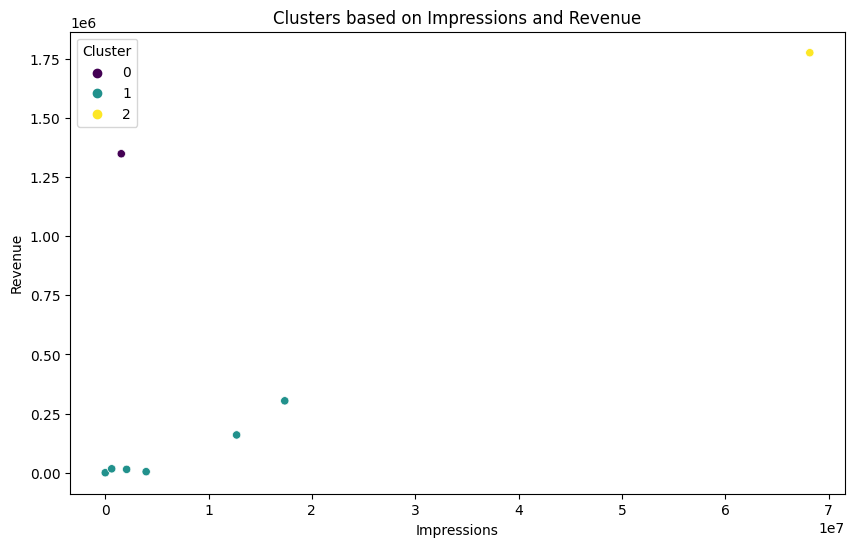

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Impressions', y='Revenue', hue='Cluster', data=performance_summary, palette='viridis')
plt.title('Clusters based on Impressions and Revenue')
plt.show()

In [26]:
X = ads_data[['Impressions', 'Clicks', 'Cost']]
y = ads_data['Conversions']

In [27]:
model = LinearRegression()
model.fit(X, y)
ads_data['Predicted Conversions'] = model.predict(X)

#### Budget Reallocation Logic

In [28]:
total_budget = 200000
min_budget_per_channel = 0.1 * total_budget

In [29]:
# Calculate budget allocation
def allocate_budget(df, total_budget):
    df['Budget Allocation'] = (df['Predicted Conversions'] / df['Predicted Conversions'].sum()) * total_budget
    return df

In [30]:
budget_allocation = allocate_budget(ads_data, total_budget)

In [31]:
# Ensure minimum budget allocation constraint
def enforce_min_budget(df, min_budget):
    df.loc[df['Budget Allocation'] < min_budget, 'Budget Allocation'] = min_budget
    return df

In [32]:

budget_allocation = enforce_min_budget(budget_allocation, min_budget_per_channel)

#### Output: Cumulated Budgets and Estimated Conversions

In [33]:
budget_summary = budget_allocation.groupby(['Platform', 'Campaign type']).agg({
    'Budget Allocation': 'sum',
    'Predicted Conversions': 'sum'
}).reset_index()

print(budget_summary)

        Platform     Campaign type  Budget Allocation  Predicted Conversions
0     Google Ads     Cross-network          3640000.0            8309.545508
1     Google Ads   Display Network          3360000.0             424.316021
2     Google Ads    Search Network          3640000.0            5606.179644
3     Google Ads           YouTube          3640000.0             211.893649
4  Microsoft Ads          Audience          3640000.0             515.688846
5  Microsoft Ads   Performance max          3500000.0             663.382853
6  Microsoft Ads  Search & content          3640000.0            2148.510263
7  Microsoft Ads          Shopping          3640000.0             651.559568


#### Visualization of Budget Allocation

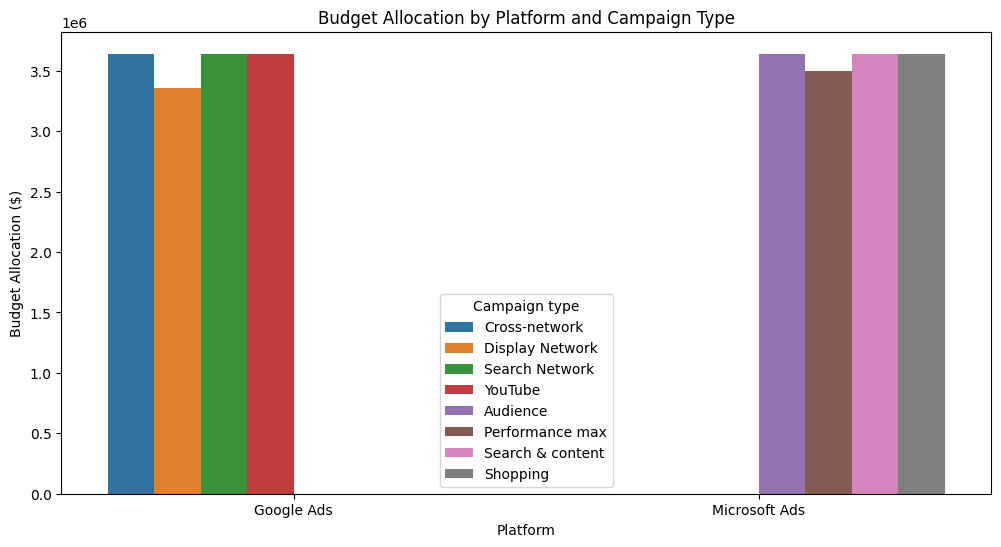

In [34]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Platform', y='Budget Allocation', hue='Campaign type', data=budget_summary)
plt.title('Budget Allocation by Platform and Campaign Type')
plt.xlabel('Platform')
plt.ylabel('Budget Allocation ($)')
plt.show()